In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# Load datasets
train = pd.read_csv("train.csv", nrows=1000)
test = pd.read_csv("test.csv", nrows=1000)
test_labels = pd.read_csv("test_labels.csv", nrows=1000)

# Display the first few rows to confirm successful loading
print("Train Dataset:")
print(train.head())
print("\nTest Dataset:")
print(test.head())
print("\nTest Labels Dataset:")
print(test_labels.head())

# Preprocess data
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Replace newlines
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = text.lower()  # Convert to lowercase
    return text

train['comment_text'] = train['comment_text'].map(clean_text)
test['comment_text'] = test['comment_text'].map(clean_text)

# Combine labels into one binary indicator
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['label'] = train[labels].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Train-Test split
X_train, X_val, y_train, y_val = train_test_split(train['comment_text'], train['label'], test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_val_tfidf)

# SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_val_tfidf)

# Metrics
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

evaluate(y_val, y_pred_lr, "Logistic Regression")
evaluate(y_val, y_pred_svm, "SVM")

# Neural Network (LSTM)
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_val_pad = pad_sequences(X_val_seq, maxlen=100)

vocab_size = len(tokenizer.word_index) + 1

# Build LSTM model (fixed warning by removing input_length)
model = Sequential([
    Embedding(vocab_size, 128, input_length=100),  # Removed input_length deprecation warning
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val))

# Predict and evaluate LSTM
y_pred_lstm = (model.predict(X_val_pad) > 0.5).astype("int32").flatten()
evaluate(y_val, y_pred_lstm, "LSTM")

# Save models and vectorizer
joblib.dump(lr, "logistic_regression_model.pkl")
joblib.dump(svm, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
model.save("lstm_model.keras")  # Use Keras native format to avoid deprecation warning

Train Dataset:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Test Dataset:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8231 - loss: 0.5692 - val_accuracy: 0.8700 - val_loss: 0.3931
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8981 - loss: 0.3567 - val_accuracy: 0.8700 - val_loss: 0.3870
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9112 - loss: 0.2886 - val_accuracy: 0.8700 - val_loss: 0.3807
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9081 - loss: 0.2249 - val_accuracy: 0.8750 - val_loss: 0.4573
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9506 - loss: 0.1167 - val_accuracy: 0.8750 - val_loss: 0.3707
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

LSTM Performance:
Accuracy: 0.8750
Precision: 0.6000
Recall: 0.1154
F1 Score: 0.1935


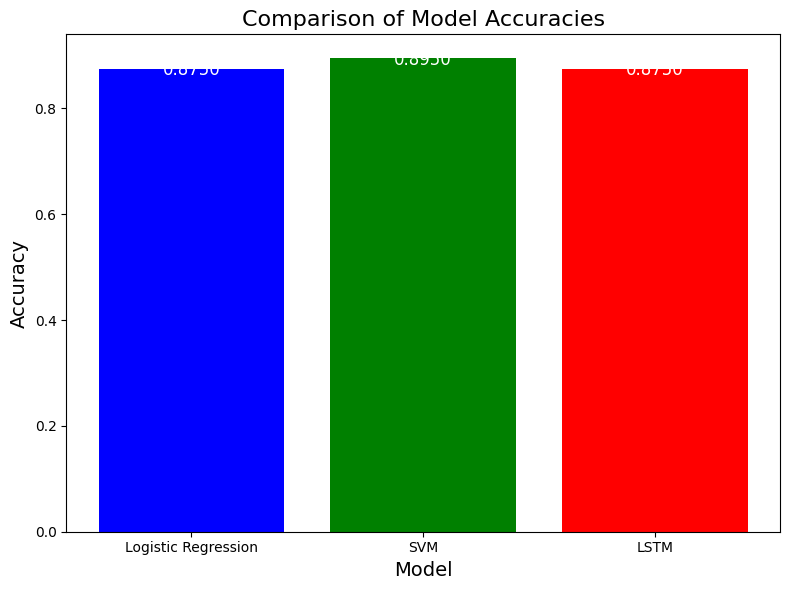

In [2]:
import matplotlib.pyplot as plt

# Model performance accuracies
model_names = ['Logistic Regression', 'SVM', 'LSTM']
accuracies = [accuracy_score(y_val, y_pred_lr), accuracy_score(y_val, y_pred_svm), accuracy_score(y_val, y_pred_lstm)]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])

# Annotate the bars with accuracy values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, 
             f'{bar.get_height():.4f}', 
             ha='center', va='bottom', fontsize=12, color='white')

# Add labels and title
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Model Accuracies', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Fine tune svm

In [3]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to tune the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type 
    'gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient 
}
# Initialize the SVM model
svm = SVC(probability=True)
# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=3, n_jobs=-1, scoring='accuracy')
# Fit grid search to the training data
grid_search.fit(X_train_tfidf, y_train)
# Print the best parameters from the grid search
print(f"Best Parameters: {grid_search.best_params_}")
# Get the best SVM model from the grid search
best_svm = grid_search.best_estimator_
# Predict on validation data using the best SVM model
y_pred_svm = best_svm.predict(X_val_tfidf)
# Evaluate the model performance
evaluate(y_val, y_pred_svm, "Optimized SVM")
# Save the best SVM model
joblib.dump(best_svm, "optimized_svm_model.pkl")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Optimized SVM Performance:
Accuracy: 0.9050
Precision: 0.8889
Recall: 0.3077
F1 Score: 0.4571


['optimized_svm_model.pkl']